In [1]:
import ppp_prediction.geneformer.perturber_utils as pu

2024-04-18 15:33:30.512000: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 15:33:31.890986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/geneformer/perturber_utils.py:153: SyntaxWarning: invalid escape sequence '\('
  return int(re.split("\(|,", str(model.bert.embeddings.position_embeddings))[1])


In [3]:
model = pu.load_model("CellClassifier", 2, "finetune_geneformer", "eval")
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(25426, 256, padding_idx=0)
      (position_embeddings): Embedding(2048, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.02, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.02, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12

In [4]:
import datasets

test_dataset = datasets.load_from_disk("tmp/imputed_200/test")

In [19]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(
    test_dataset.select_columns(["input_ids", "eid"]).with_format("torch"),
    batch_size=32,
)

In [31]:
import torch

model.eval()
pred = []

with torch.no_grad():

    for batch in test_dataloader:
        o = model(batch["input_ids"].cuda())
        o = torch.nn.functional.softmax(o.logits, dim=-1)[:, 1]
        pred.append(o.cpu())

pred = torch.cat(pred).numpy()

In [35]:
test_score = (
    test_dataset.select_columns(["eid", "incident_cad"]).to_pandas().assign(pred=pred)
)
test_score

,eid,incident_cad,pred
0,2883530.0,0,0.013248
1,2867444.0,0,0.037029
2,5869793.0,0,0.042655
3,4880838.0,0,0.037637
4,3987428.0,0,0.032466
...,...,...,...
15427,5241912.0,1,0.084166
15428,3851862.0,1,0.011440
15429,1144512.0,0,0.055816
15430,1177099.0,0,0.031597


<Axes: xlabel='pred', ylabel='Density'>

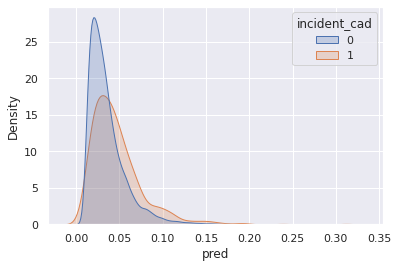

In [36]:
import seaborn as sns

sns.kdeplot(data=test_score, x="pred", hue="incident_cad", common_norm=False, fill=True)

In [37]:
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    auc,
)


from tqdm.rich import tqdm
import numpy as np

from statsmodels.stats.multitest import multipletests


import statsmodels.api as sm

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
)
from scipy.stats import pearsonr, spearmanr


def generate_multipletests_result(df, pvalue_col="pvalue", alpha=0.05, method="fdr_bh"):
    df = df.copy()
    pvalue_series = df[pvalue_col]
    reject, pvals_corrected, _, _ = multipletests(
        pvalue_series, alpha=alpha, method="fdr_bh"
    )
    df["pval_corrected"] = pvals_corrected
    df["reject"] = reject
    return df


def find_best_cutoff(fpr, tpr, thresholds):
    diff = tpr - fpr
    Youden_index = np.argmax(diff)
    optimal_threshold = thresholds[Youden_index]
    optimal_FPR, optimal_TPR = fpr[Youden_index], tpr[Youden_index]
    return optimal_threshold, optimal_FPR, optimal_TPR


def cal_binary_metrics(y, y_pred):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    AUC = roc_auc_score(y, y_pred)
    # by best youden

    optim_threshold, optim_fpr, optim_tpr = find_best_cutoff(fpr, tpr, thresholds)
    y_pred_binary = (y_pred > optim_threshold).astype(int)
    ACC = accuracy_score(y, y_pred_binary)
    macro_f1 = f1_score(y, y_pred_binary, average="macro")
    sensitivity = optim_tpr
    specificity = 1 - optim_fpr
    precision, recall, _ = precision_recall_curve(y, y_pred)
    APR = auc(recall, precision)

    return {
        "AUC": AUC,
        "ACC": ACC,
        "Macro_F1": macro_f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "APR": APR,
    }

In [38]:
cal_binary_metrics(test_score.incident_cad, test_score.pred)

{'AUC': 0.6285703266853697,
 'ACC': 0.6671850699844479,
 'Macro_F1': 0.47085560857556946,
 'Sensitivity': 0.539015606242497,
 'Specificity': 0.6745667511473389,
 'APR': 0.09274996784703754}